# Результаты A/B теста
</center>

> Если орел — я выиграла, если решка — ты проиграл.

$\qquad$ Рейчел из друзей


Будем анализировать А/Б тест, проведенный на реальных пользователях Яндекса.

### Описание данных:

* `userID` — уникальный идентификатор пользователя
* `browser` — браузер, который использовал userID
* `slot` — в каком статусе пользователь участвовал в исследовании (exp = видел измененную страницу, control = видел неизменную страницу)
* `n_clicks` — количество кликов, которые пользоваль совершил за n_queries
* `n_queries` — количество запросов, который совершил userID, пользуясь браузером browser
* `n_nonclk_queries` — количество запросов пользователя, в которых им не было совершено ни одного клика

Замечание: не все люди используют только один браузер, поэтому в столбце userID есть повторяющиеся идентификаторы. В предлагаемых данных уникальным является сочетание userID и browser.

In [3]:
import numpy as np
import pandas as pd
from scipy import stats as sts
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('data/ab_browser_test.csv',sep=',')

df['click_per_queries'] = df['n_clicks']/df['n_queries']
df['empty_query_share'] = df['n_nonclk_queries']/df['n_queries']

print(df.shape)
df.head()

(566134, 8)


,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries,click_per_queries,empty_query_share
0,1,Browser #2,exp,23,32,19,0.718750,0.593750
1,3,Browser #4,exp,3,4,2,0.750000,0.500000
2,5,Browser #4,exp,29,35,16,0.828571,0.457143
3,6,Browser #4,control,12,6,0,2.000000,0.000000
4,7,Browser #4,exp,54,68,30,0.794118,0.441176


Будем работать с числом кликов на количество пользовательских сессий. 

> Вообще, это ratio-метрика и к ней нужен особый подход. Пока что будем это игнорировать. В целом, можно откатиться к кликам и работать с их средним, но методологически правильнее отнормировать их на число сессий.

Посчитаем, насколько в группе exp больше пользовательских кликов по сравнению с группой control в процентах от числа кликов в контрольной группе.

In [12]:
# ваш код

100 * (df.groupby('slot')['n_clicks'].sum()['exp']/df.groupby('slot')['n_clicks'].sum()['control'] - 1)

1.6135689824415822

Поскольку данных достаточно много (порядка полумиллиона уникальных пользователей), отличие в несколько процентов может быть не только практически значимым, но и значимым статистически. Последнее утверждение нуждается в дополнительной проверке.

## Часть 1: анализ А/Б-теста

Внимательнее посмотрим на то, что происходит с кликами в наших пользовательских сессиях. Для этого построим для контрольной и тестовой групп визуализации и ответим на следующие вопросы:

- Правда ли, что в данных есть много выбросов?
- Правда ли, что данные пришли из одного распределения и в группах отличия только в сдвиге (для ответа на этот вопрос: 1) построим для обеих групп квантили распределений с шагом в 0.1 и сравним их между собой; 2) сравним гистограмы по форме)
- Подумаем, какие тесты применимы здесь для проведения А/B.

**Ответы:**

- 

<Axes: ylabel='click_per_queries'>

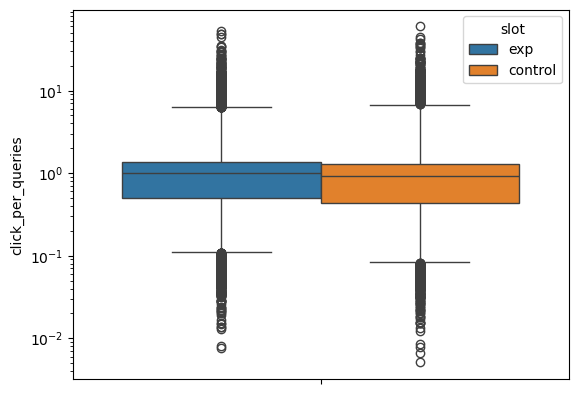

In [16]:
sns.boxplot(data=df, y='click_per_queries', hue='slot', orient='v', log_scale=True)

In [52]:
q1, q2 = np.quantile(df[df['slot']=='exp']['click_per_queries'],[0.25, 0.75])
IQR = abs(q2 - q1)
left, right = q1 - 1.0 * IQR, q2 + 1.0 * IQR

exp = df[df['slot']=='exp']['click_per_queries']
control = df[df['slot']=='control']['click_per_queries']

q1_exp, q2_exp = np.quantile(exp,[0.25, 0.75])
IQR_exp= abs(q2_exp - q1_exp)
left_exp, right_exp = q1_exp - 1.0 * IQR_exp, q2_exp + 1.0 * IQR_exp

exp_clear =  exp.loc[(exp >= left_exp) & (exp <= right_exp)]
exp_outlier = exp.loc[(exp < left_exp) | (exp > right_exp)]

q1_control, q2_control = np.quantile(control,[0.25, 0.75])
IQR_control = abs(q2_control - q1_control)
left_control, right_control = q1_control - 1.0 * IQR_control, q2_control + 1.0 * IQR_control

control_clear =  control.loc[(control >= left_control) & (control <= right_control)]
control_outlier = control.loc[(control < left_control) | (control > right_control)]

control_outlier.shape, exp_outlier.shape

((21477,), (22077,))

<Axes: title={'center': 'Control group'}, xlabel='click_per_queries', ylabel='Count'>

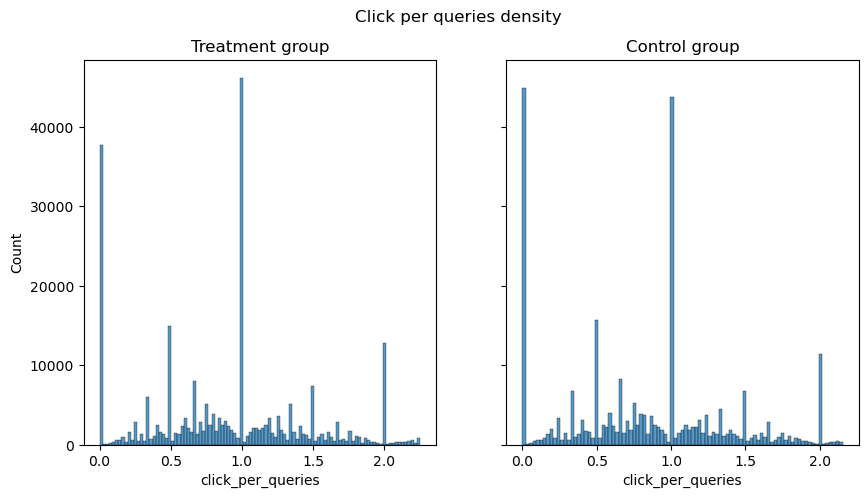

In [58]:
fig, axes = plt.subplots(1,2, sharey=True, figsize=(10,5))
fig.suptitle('Click per queries density')

axes[0].set_title('Treatment group')
sns.histplot(exp_clear,ax=axes[0])

axes[1].set_title('Control group')
sns.histplot(control_clear, ax=axes[1])

In [64]:
df_clear = df.iloc[exp_clear.index.to_list()+control_clear.index.to_list()]

<Axes: ylabel='click_per_queries'>

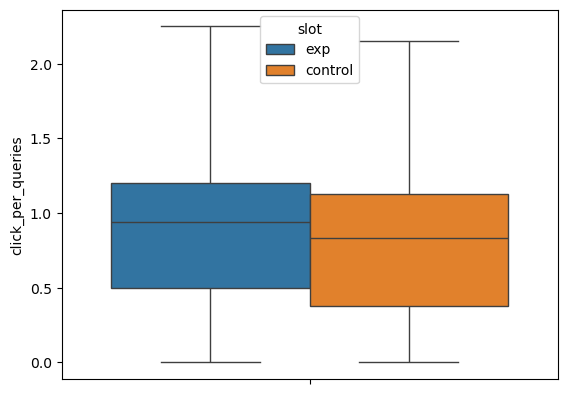

In [65]:
sns.boxplot(data=df_clear, y='click_per_queries', hue='slot', orient='v')

In [72]:
df['click_per_queries'].min()

0.0

<Axes: >

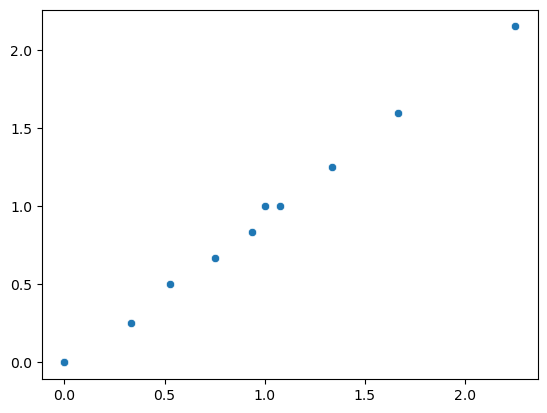

In [78]:
exp_quantiles = []
control_quantiles = []

quantile_levels = np.linspace(0, 1, 11)

for q in quantile_levels:
    exp_quantiles.append(np.quantile(exp_clear, q))
    control_quantiles.append(np.quantile(control_clear, q))

sns.scatterplot(x=exp_quantiles, y=control_quantiles)

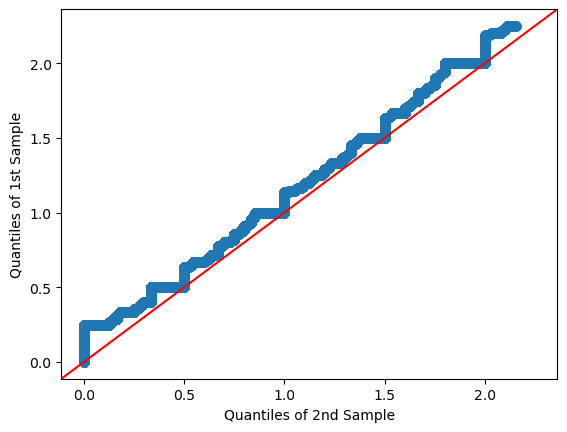

In [70]:
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot_2samples

import matplotlib.pyplot as plt

pp_exp = sm.ProbPlot(exp_clear)
pp_control = sm.ProbPlot(control_clear)

sm.qqplot_2samples(pp_exp, pp_control, line='45')
plt.show()

__[10 баллов]__ Скорее всего, в пункте выше вы написали, что $z$-тест нам не подходит из-за выбросов. Однако, мы не можем наверняка знать, насколько серьёзное влияние эти выбросы оказали на ЦПТ и сломали ли они её. Если посчитать по выброкам средние и медианы, они окажутся очень похожими.

Бутстрап — это асимптотическая техника для получения критических значений статистики. Давайте проведём следующую процедуру. Ограничимся в рамках неё контрольной группой. Поскольку мы не знаем истинного распределения генеральной совокупности, мы можем применить бутстрэп, чтобы понять, как распределена z-статистика и сравнить её распределение с нормальным. 

Поскольку мы знаем, что $\text{Var}(\bar X_n) = \frac{\sigma^2}{n}$, нам не надо будет делать бутстрэп в бутстрэпе. Когда мы знаем для нашей статистики форму дисперсии, бутстрэп называется __параметрическим.__

1. Получите из данных `n_boot_samples` псевдовыборок,
2. По каждой из этих выборок посчитайте среднее и его дисперсию,
3. Рассчитайте значение $z$-статистики,
4. Для получившегося вектора из $z$-статистик постройте `qq-plot` с помощью ` scipy.stats.probplot` для нормального распределения.

Сделайте выводы.

In [ ]:
# ваш код 

__[10 баллов]__ Осторожно, спойлеры! В прошлом пункте у вас получилась картинка, на которой хвосты распределения немного отличаются от стандартного нормального. Давайте сделаем вид, что всё хорошо и отличия на хвостах нет. Проверьте гипотезу о равенстве средних между группами с помощью $z-$теста на уровне значимости $1\%$.

In [ ]:
# ваш код 

__[10 баллов]__ Давайте попробуем понять, какими при таких объёмах выборки оказываются MDE и ошибка второго рода. Конечно, же сделать это надо до проведения АБ-теста. Но не мы его готовили... При решении этого пункта выберите какое-то адекватное значение MDE и получите отталкиваясь от него ошибку второго рода.

Формула для расчета числа наблюдений __для одной группы:__

$$
n_{\text{one group}} = \frac{(\sigma_A^2 + \sigma_B^2) \cdot (z_{1-\frac{\alpha}{2}} + z_{1-\beta})^2}{MDE^2},
$$

In [ ]:
# ваш код 

__[10 баллов]__ Хвосты отличаются от стандартного нормального. По хорошему, для проверки гипотезы нужно использовать бутстрап. В контексте средних, на бутстрап можно смотреть как на технику, которая уточняет, насколько сильно хвосты распределения стали тяжелее по сравнению с ЦПТ. 

Проверьте гипотезу с помощью бутстрапа! Воспользуйтесь следующим алгоритмом с лекции:

1. Посчитайте наблюдаемое значение статистики.
2. Пусть $\bar h$ - это среднее посчитанное по обеим выборкам вместе. Создайте две новые выборки $$x'_i = x_i - \bar x + \bar h \\ y'_i = y_i - \bar y + \bar h.$$ Такое рецентрирование сдвинет обе выборки к общему среднему и  позволит заложить в симуляцию информацию о верности нулевой гипотезы. 
3. Сбутстрапируйте выборки $x^{*}$ и $y^{*}$ из $x'$ и $y'$. Рассчитайте значение z-статистики. Повторит процедуру $B$ раз.
4. Для оценки `p-value` воспользуйтесь формулой:

$$
2 * \frac{1}{B} \sum_{i=1}^B [z_i^{*} \ge z_{obs}]
$$

In [ ]:
# ваш код 

__Ответьте на следующие вопросы:__

- Изменились ли выводы АБ-теста?
- Насколько сильно критическое значение статистики, полученной с помощью бутстрэпа, отличается от киритческого значения нормального распределения?
- Какую из ошибок (1 рода/2 рода) вы будете чаще совершать, если в ситуации с толстыми хвостами будете пользоваться нормальным распредеелнием? Насколько чаще будет возникать эта ошибка?

__[10 баллов]__ Насколько больше наблюдений нам необходимо для проверки гипотезы по сравнению с z-тестом? Для ответа на этот вопрос подставьте критические значение из бустрап-распределения в формулу для оценки числа наблюдений. В качестве MDE возьмите величину, которую вы сами зафикисировали в прошлых пунктах. В качестве ошибки второго рода возьмите получившуюся при рассчётах величину.

In [ ]:
# ваш код

__[10 баллов]__ Проверьте ту же гипотезу тестом Манна-Уитни. Используйте для этого функцию `scipy.stats.mannwhitneyu`.

In [ ]:
# ваш код 

При $n,m \to \infty$ статистика Манна-Уитни сходится к нормальному распределению со следующими параметрами: 

$$
U \Rightarrow N \left( \frac{n_T \cdot n_C}{2}, \frac{n_T \cdot n_C \cdot (n_T + n_C + 1)}{12} \right)
$$

Отталкиваясь от этого приближения, определите сколько наблюдений нам необходимо для проверки гипотезы для тех же MDE и ошибки 2 рода, что и у z-теста/бустрапа.

In [ ]:
# ваш код

__[10 баллов]__ У многих аналитиков с теста Манна-Уитни подгорает жепа. Это происходит из-за того, что на практике его часто используют довольно бездумно. [Вот один из свежих примеров бомбежа.](https://habr.com/ru/companies/avito/articles/709596/) 

В нашем кейсе, если аккуратно посчитать квантили обоих распределений, можно увидеть, что в тестовой группе квантили и правда съехали вправо, а форма гистограмм не изменилась. В целом, это знак, что тест можно спокойно применять. Однако, квантили левее $0.1$ не поменялись. 

Вместо тесто Манна-Уитни на сдвиг распределения, мы можем попробовать проверить гипотезу о том, что наше распределение, в принципе, как-то поменялось. Для таких гипотез обычно используются критерии согласия. Проверьте гипотезу о том, что распределения тестовой и контрольной групп совпадают с помощью теста Колмогорова-Смирнова `scipy.stats.ks_2sam`.

In [ ]:
# ваш код 

Насколько сильно друг от друга отличаются p-значения этих тестов? Как думаете, почему отличие именно такое?

__Ответ:__

## Часть 2: CUPED

Попробуем натянуть сову на глобус. Давайте сделаем вид, что на самом деле первые $50\%$ таблицы это выборка, которая у нас была до эксперимента. Попробуем провернуть CUPED. 

__[10 баллов]__ рассчитайте значение стандартной ошибки для $z$-статистики по второй части выборки. С помощью CUPED мы будем пытаться уменьшить значение этой ошибки.

In [ ]:
# ваш код

__[20 баллов]__ теперь проверните CUPED. Используйте значение целевой переменной из первой части выборки как ковариату.

Для оценки линейных моделей используйте пакет `statsmodels`. Пример того, как это можно делать [есть тут.](https://github.com/FUlyankin/matstat-AB/blob/main/week13_linreg/11_python_regression.ipynb) Предполагайте, что в данных есть гетероскедастичность. Для её фикса пользуйтесь `HC-3`.

Насколько у нас получилось уменьшить стандартную ошибку?

In [ ]:
# ваш код

__[20 баллов]__ Ровно по той же схеме проверните CUPAC. В качестве базовой модели возьмите какой-нибудь градиентный бустинг. Насколько у нас получилось уменьшить стандартную ошибку? 

In [ ]:
# ваш код

__[10 баллов]__ Финальный вопрос! А как использовать эту новую стандартную ошибку в формуле для рассчёта числа наблюдений? Выясните при выбранном выми MDE, какая у нас будет ошибка второго рода в CUPED и CUPAC, если в АБ-тесте будет участвовать только половина наблюдений.

In [ ]:
# ваш код